# Decision Trees and Ensemble Learning

In this project, we are going to work with the [Credit Scoring dataset](https://github.com/gastonstat/CreditScoring/), a dataset that contains information about loan customers, where for each application the information if it was paid back successfully or not is known. The goal is to create a model that can predict the risk of a customer not returning the loan money.

This is a classification problem, and we are going to approach it with ensemble learning models. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/CreditScoring.csv')

df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data validation
We will map the categorical values into their real names, to facilitate the EDA. The mapping will be performed according to this [script](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R).

For example, for the 'status' column we have:

In [4]:
status_values = {1: 'ok',
                 2: 'default',
                 0: 'unk'
                }

df['status'] = df['status'].map(status_values)

Now, we repeat this to the other categorical columns:

In [5]:
home_values = {
1: 'rent',
2: 'owner',
3: 'private',
4: 'ignore',
5: 'parents',
6: 'other',
0: 'unk'
}

marital_values = {
1: 'single',
2: 'married',
3: 'widow',
4: 'separated',
5: 'divorced',
0: 'unk'
}

records_values = {
1: 'no',
2: 'yes',
0: 'unk'
}

job_values = {
1: 'fixed',
2: 'partime',
3: 'freelance',
4: 'others',
0: 'unk'
}

df['home'] = df['home'].map(home_values)
df['marital'] = df['marital'].map(marital_values)
df['records'] = df['records'].map(records_values)
df['job'] = df['job'].map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [6]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The max values of 99999999.0 in the 'income', 'assets' and 'debt' columns are suspect. In fact, this is how the missing values were dealt with in this dataset. Let's change them to 'NaN':

In [7]:
for col in ['income', 'assets', 'debt']:
    df[col].replace(to_replace={99999999.0: np.nan}, inplace=True)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Now, let's look at the target variable, 'status':

In [8]:
df['status'].value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

Only one client has the 'unknown' status, which will not be useful in this analysis; thus, the sample will be removed from the dataframe.

In [9]:
df = df[df.status != 'unk']

## Data Preparation
The data will be split into train/validation/test in a 60%/20%/20% ratio.

In [10]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [11]:
print("Size of full set: {}".format(len(df)))
print("Size of train set: {} -> {:0.1f} %".format(len(df_train), 100 * len(df_train) / len(df)))
print("Size of validation set: {} -> {:0.1f} %".format(len(df_val), 100 * len(df_val) / len(df)))
print("Size of test set: {} -> {:0.1f} %".format(len(df_test), 100 * len(df_test) / len(df)))

Size of full set: 4454
Size of train set: 2672 -> 60.0 %
Size of validation set: 891 -> 20.0 %
Size of test set: 891 -> 20.0 %


The dataset contains the NaN values inputted in the previous steps, we will substitute them with 0's.

In [12]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [13]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

Next, we will deal with the target variable, "status". We are going to change it to map "default" to 1 and "ok" to 0.

In [14]:
y_train = (df_train['status'] == "default").values
y_val = (df_val['status'] == "default").values

df_train.drop('status', axis=1, inplace=True)
df_val.drop('status', axis=1, inplace=True)

### One-Hot Encoding
Now, the categorical variables will be one-hot encoded. We will do that using DictVectorizer.

In [15]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Decision Tree Classifier
For this project, a Decision Tree Classifier will be trained to solve the problem. 

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 1.000
ROC AUC Validation = 0.650


The model is overfitting. We need to tune the tree parameters to avoid this problem.

In [17]:
from sklearn.tree import export_text

tree_text = export_text(dt, feature_names=dv.feature_names_)

print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- seniority <= 0.50
|   |   |   |   |--- class: True
|   |   |   |--- seniority >  0.50
|   |   |   |   |--- income <= 50.50
|   |   |   |   |   |--- price <= 1250.00
|   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- price >  1250.00
|   |   |   |   |   |   |--- assets <= 2500.00
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- assets >  2500.00
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |--- income >  50.50
|   |   |   |   |   |--- home=rent <= 0.50
|   |   |   |   |   |   |--- price <= 720.00
|   |   |   |   |   |   |   |--- amount <= 425.00
|   |   |   |   |   |   |   |   |--- age <= 25.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- age >  25.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- amount >  425.00
|   |   |   |   |   |   |   |   |--- 

This tree is too deep, so we will begin by limiting its maximum depth with the max_depth parameter.

In [18]:
dt = DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names=dv.feature_names_)

print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True



This tree is much shallower. Let's see how it performs:

In [19]:
y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 0.705
ROC AUC Validation = 0.669


The model is not overfitting anymore, but the result in the validation set is still low. This is because the model is too simple.

Let's first tune the max_depth parameter:

In [20]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.751
  10 -> 0.681
  15 -> 0.662
  20 -> 0.652
None -> 0.662


The best values for the ```max_depth``` parameter are 4, 5 and 6. Now, we we will tune the ```min_samples_leaf``` parameter, that is, the minimum number of samples required to be at both left and right branches after a node splitting.

In [21]:
for m in [4, 5, 6]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))

    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.767
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.759
5 -> 0.762
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.772
100 -> 0.776
200 -> 0.768



The best parameters are ```max_depth``` = 6 and ```min_sample_leaf``` = 15. Let's use them to train the final model.

In [22]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

dt.fit(X_train, y_train)

y_pred_train = dt.predict_proba(X_train)[:, 1]
y_pred_val = dt.predict_proba(X_val)[:, 1]

dt_score_train = roc_auc_score(y_train, y_pred_train)
dt_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(dt_score_train))
print("ROC AUC Validation = {:0.3f}".format(dt_score_val))

ROC AUC Train = 0.861
ROC AUC Validation = 0.785


### Random Forest Classifier
The best way to use decision trees is to train many of them and choose the best result based on voting, a method which is called ensemble learning. In particular, ensemble learning models using decision trees as voters are called Random Forest.

In [23]:
from sklearn.ensemble import RandomForestClassifier

aucs = []
for n in range(10, 201, 10):

    rfc = RandomForestClassifier(n_estimators=n, random_state=3)
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%3s -> %.3f' % (n, auc))

    aucs.append(auc)

 10 -> 0.781
 20 -> 0.801
 30 -> 0.813
 40 -> 0.815
 50 -> 0.816
 60 -> 0.817
 70 -> 0.818
 80 -> 0.818
 90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


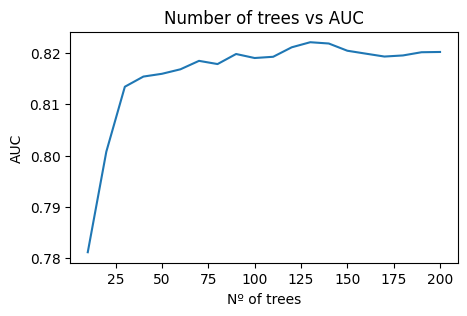

In [24]:
num_trees = range(10, 201, 10)

plt.figure(figsize=(5,3))
plt.plot(num_trees, aucs)
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs AUC')
plt.show()

We can see that after 130 trees, adding more trees is useless as the AUC stops increasing. 

Now, let's tune the parameter ```n_estimators``` along with ```max_depth```:

In [25]:
all_aucs_depth = {}

for depth in [5, 10, 20]:
    print('max_depth: %s' % depth)

    aucs = []
    for trees in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=trees, 
                                     max_depth=depth, 
                                     random_state=1)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%3s -> %.3f' % (trees, auc))

        aucs.append(auc)
    
    print()

    all_aucs_depth[depth] = aucs

max_depth: 5
 10 -> 0.788
 20 -> 0.798
 30 -> 0.800
 40 -> 0.800
 50 -> 0.800
 60 -> 0.801
 70 -> 0.802
 80 -> 0.803
 90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

max_depth: 10
 10 -> 0.791
 20 -> 0.808
 30 -> 0.812
 40 -> 0.818
 50 -> 0.817
 60 -> 0.819
 70 -> 0.820
 80 -> 0.820
 90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

max_depth: 20
 10 -> 0.776
 20 -> 0.803
 30 -> 0.813
 40 -> 0.817
 50 -> 0.815
 60 -> 0.813
 70 -> 0.814
 80 -> 0.815
 90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



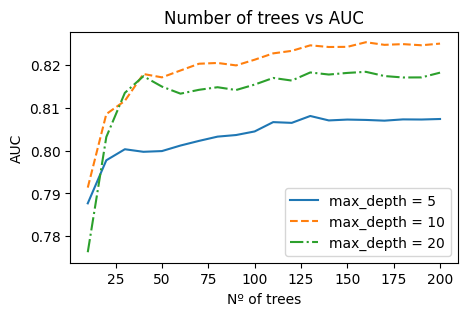

In [26]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_aucs_depth[5], '-', label='max_depth = 5')
plt.plot(num_trees, all_aucs_depth[10], '--', label='max_depth = 10')
plt.plot(num_trees, all_aucs_depth[20], '-.', label='max_depth = 20')
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

The best AUC results are with ```max_depth``` = 10. Thus, let's fix this value and tune the ```min_samples_leaf``` parameter.

In [27]:
all_aucs_leaf = {}

for samples in [3, 5, 10]:
    print('min_samples_leaf: %s' % samples)

    aucs = []
    for trees in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=trees,
                                     max_depth=10, 
                                     min_samples_leaf=samples, 
                                     random_state=1)
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%3s -> %.3f' % (trees, auc))

        aucs.append(auc)
    
    print()

    all_aucs_leaf[samples] = aucs

min_samples_leaf: 3
 10 -> 0.811
 20 -> 0.820
 30 -> 0.823
 40 -> 0.822
 50 -> 0.823
 60 -> 0.823
 70 -> 0.822
 80 -> 0.823
 90 -> 0.823
100 -> 0.823
110 -> 0.823
120 -> 0.825
130 -> 0.824
140 -> 0.825
150 -> 0.825
160 -> 0.826
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

min_samples_leaf: 5
 10 -> 0.813
 20 -> 0.815
 30 -> 0.818
 40 -> 0.820
 50 -> 0.821
 60 -> 0.823
 70 -> 0.822
 80 -> 0.823
 90 -> 0.822
100 -> 0.824
110 -> 0.825
120 -> 0.825
130 -> 0.825
140 -> 0.824
150 -> 0.825
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.826
200 -> 0.825

min_samples_leaf: 10
 10 -> 0.810
 20 -> 0.818
 30 -> 0.822
 40 -> 0.822
 50 -> 0.822
 60 -> 0.822
 70 -> 0.819
 80 -> 0.820
 90 -> 0.820
100 -> 0.819
110 -> 0.820
120 -> 0.820
130 -> 0.821
140 -> 0.820
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.820
190 -> 0.820
200 -> 0.820



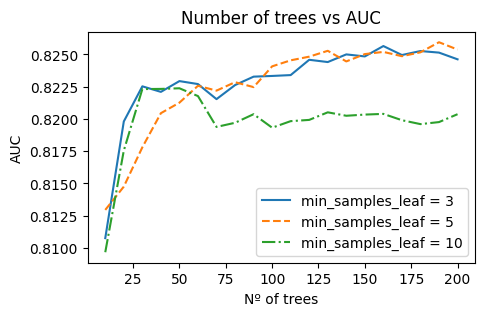

In [28]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_aucs_leaf[3], '-', label='min_samples_leaf = 3')
plt.plot(num_trees, all_aucs_leaf[5], '--', label='min_samples_leaf = 5')
plt.plot(num_trees, all_aucs_leaf[10], '-.', label='min_samples_leaf = 10')
plt.xlabel('Nº of trees')
plt.ylabel('AUC')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

The best value is ```min_samples_leaf``` = 5, and the number of estimators that yielded the best results is 200. So, we set these parameters and train our final model:

In [29]:
rfc_final = RandomForestClassifier(n_estimators=200, 
                                   max_depth=10, 
                                   min_samples_leaf=5,
                                   random_state=1)

rfc_final.fit(X_train, y_train)

y_pred_train = rfc_final.predict_proba(X_train)[:, 1]
y_pred_val = rfc_final.predict_proba(X_val)[:, 1]

rfc_score_train = roc_auc_score(y_train, y_pred_train)
rfc_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(rfc_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfc_score_val))

ROC AUC Train = 0.940
ROC AUC Validation = 0.825


Although the model overfits a little, the validation score of 0.825 is much better than our first models without parameter tuning. 

## Gradient Boosting
Finally, let's try another ensemble learning approach: gradient boosting. It consists of training models sequentially, with each subsequent model trying to correct the errors of the previous model. For this, we are going to use the XGBoost (short for "Extreme Gradient Boosting") package.

Before training the XGBoost model, the data will be wrapped into a ```DMatrix``` — a special data structure for finding splits efficiently.

In [30]:
import xgboost as xgb

# Creating a DMatrix for training and validation sets
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

Now, the model will be trained using the ```.train``` method, which receives the following arguments:
* ```xgb_params```: the parameters for training;
* ```dtrain```: the dataset for training, an instance of ```DMatrix```;
* ```num_boost_round```: the number of trees to train. 

As this is a classification problem, we set the parameter ```'objective': 'binary:logistic'``` inside the ```xgb_params``` dictionary.

In [31]:
xgb_params = {
'eta': 0.3,
'max_depth': 6,
'min_child_weight': 1,
'objective': 'binary:logistic',
'nthread': 8,
'seed': 1,
}

model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred_train = model_xgb.predict(dtrain)
y_pred_val = model_xgb.predict(dval)

xgb_score_train = roc_auc_score(y_train, y_pred_train)
xgb_score_val = roc_auc_score(y_val, y_pred_val)

print("ROC AUC Train = {:0.3f}".format(xgb_score_train))
print("ROC AUC Validation = {:0.3f}".format(xgb_score_val))

ROC AUC Train = 0.946
ROC AUC Validation = 0.815


Although an AUC of 0.815 is a good result, it is slightly worse than the RandomForest AUC of 0.825.

Let's tune the parameters of this XGBoost model and see if we can get any improvement in the score. First, we define a watchlist with the train and validation datasets, to monitor the model results. We also need to include a new parameter to our parameters dictionary ```xgb_params```: the ```eval_metric```  , which here is the ```auc```.

In [32]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {'eta': 0.3,
             'max_depth': 6,
             'min_child_weight': 1,
             'objective': 'binary:logistic',
             'nthread': 8,
             'seed': 1,
             'eval_metric': 'auc'}

Now, the model will be trained with some extra paraeters:
* `evals`: the watchlist;
* `evals_result`: an empty dictionary into which the scores for the train and validation datasets will be stored;
* ``verbose_eval``: how often we are going to display the results.

Let's train the model and plot a visualization of its performance.

In [33]:
evals_result = {}
model_xgb = xgb.train(xgb_params, 
                      dtrain,
                      num_boost_round=100,
                      evals=watchlist,
                      evals_result=evals_result, 
                      verbose_eval=10)

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.95002	val-auc:0.81558
[20]	train-auc:0.97316	val-auc:0.81775
[30]	train-auc:0.98772	val-auc:0.81787
[40]	train-auc:0.99456	val-auc:0.81387
[50]	train-auc:0.99688	val-auc:0.81128
[60]	train-auc:0.99889	val-auc:0.80801
[70]	train-auc:0.99944	val-auc:0.80732
[80]	train-auc:0.99985	val-auc:0.80677
[90]	train-auc:0.99992	val-auc:0.80637
[99]	train-auc:0.99998	val-auc:0.80546


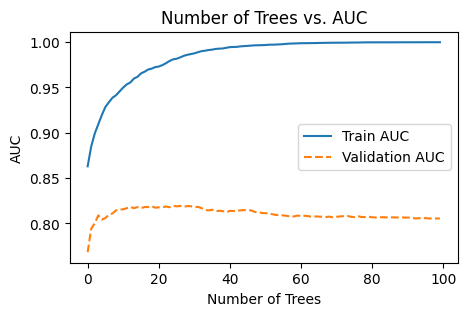

In [34]:
train_aucs = evals_result['train']['auc']
val_aucs = evals_result['val']['auc']

plt.figure(figsize=(5, 3))
plt.plot(range(len(train_aucs)), train_aucs, label='Train AUC')
plt.plot(range(len(val_aucs)), val_aucs, '--', label='Validation AUC')
plt.title('Number of Trees vs. AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.legend()
plt.show()

With increasing number of trees, the model performance in the training dataset keeps increasing, which is expected as the XGBoost always tries to fix the errors of the previous iterations of the algorithm. But in the validation dataset, the AUC decreases when more trees are added. This is because the model becomes more complex and prone to overfitting.

Now, let's fine tune other parameters along with the number of trees. Let's begin by the learning rate, the `eta` paramater.

In [35]:
eta_scores = []
for eta in [0.01, 0.05, 0.1, 0.3]:
    xgb_params = {'eta': eta,
                'max_depth': 6,
                'min_child_weight': 1,
                'objective': 'binary:logistic',
                'nthread': 8,
                'seed': 1,
                'eval_metric': 'auc'}

    print("ETA:", eta)
    evals_result = {} 
    model_xgb = xgb.train(xgb_params, 
                          dtrain,
                          num_boost_round=500, 
                          evals=watchlist,
                          evals_result=evals_result,  
                          verbose_eval=100)
    eta_scores.append(evals_result['val']['auc'])
                      

ETA: 0.01
[0]	train-auc:0.86300	val-auc:0.76818
[100]	train-auc:0.91428	val-auc:0.80422
[200]	train-auc:0.93669	val-auc:0.81131
[300]	train-auc:0.95127	val-auc:0.81543
[400]	train-auc:0.96118	val-auc:0.81837
[499]	train-auc:0.96815	val-auc:0.82168
ETA: 0.05
[0]	train-auc:0.86300	val-auc:0.76818
[100]	train-auc:0.96827	val-auc:0.82078
[200]	train-auc:0.98866	val-auc:0.82003
[300]	train-auc:0.99659	val-auc:0.81636
[400]	train-auc:0.99887	val-auc:0.81382
[499]	train-auc:0.99982	val-auc:0.81222
ETA: 0.1
[0]	train-auc:0.86300	val-auc:0.76818
[100]	train-auc:0.99056	val-auc:0.82371
[200]	train-auc:0.99919	val-auc:0.81770
[300]	train-auc:0.99998	val-auc:0.81187
[400]	train-auc:1.00000	val-auc:0.81201
[499]	train-auc:1.00000	val-auc:0.81226
ETA: 0.3
[0]	train-auc:0.86300	val-auc:0.76818
[100]	train-auc:0.99998	val-auc:0.80508
[200]	train-auc:1.00000	val-auc:0.80024
[300]	train-auc:1.00000	val-auc:0.80037
[400]	train-auc:1.00000	val-auc:0.79891
[499]	train-auc:1.00000	val-auc:0.79843


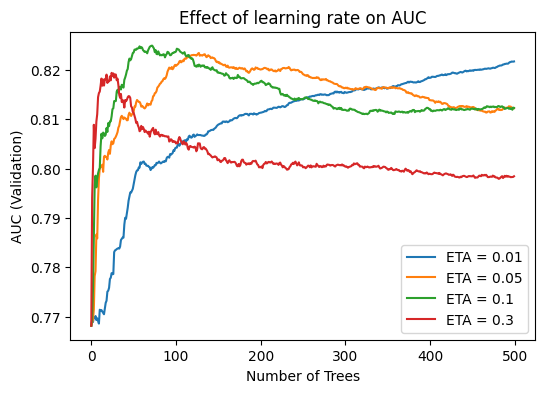

In [36]:
num_trees = range(len(eta_scores[0]))

plt.figure(figsize=(6, 4))
plt.plot(num_trees, eta_scores[0], '-', label='ETA = 0.01')
plt.plot(num_trees, eta_scores[1], '-', label='ETA = 0.05')
plt.plot(num_trees, eta_scores[2], '-', label='ETA = 0.1')
plt.plot(num_trees, eta_scores[3], '-', label='ETA = 0.3')
plt.title('Effect of learning rate on AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC (Validation)')
plt.legend()
plt.show()

The ``eta`` = 0.1 has shows the highest peak, and reaches it with less than 100 iterations. Its noticeable that ``eta`` = 0.01 score keeps growing with the number of trees, and will probably reach the same peak as ``eta`` = 0.1 after 500 iterations, but that would be computationally expensive. Thus, the best model is that with ``eta`` = 0.1.

Now, let's tune the `max_depth` parameter. The default value is 6, so let's also try 3, 4 and 10. 

In [37]:
eta_scores = []
for max_depth in [3, 4, 6, 10]:
    xgb_params = {'eta': 0.1,
                  'max_depth': max_depth,
                  'min_child_weight': 1,
                  'objective': 'binary:logistic',
                  'nthread': 8,
                  'seed': 1,
                  'eval_metric': 'auc'}

    print("max_depth:", max_depth)
    evals_result = {} 
    model_xgb = xgb.train(xgb_params, 
                          dtrain,
                          num_boost_round=500, 
                          evals=watchlist,
                          evals_result=evals_result,  
                          verbose_eval=100)
    eta_scores.append(evals_result['val']['auc'])                     

max_depth: 3
[0]	train-auc:0.77424	val-auc:0.73571
[100]	train-auc:0.91801	val-auc:0.83221
[200]	train-auc:0.94334	val-auc:0.83512
[300]	train-auc:0.95733	val-auc:0.83173
[400]	train-auc:0.96875	val-auc:0.82846
[499]	train-auc:0.97642	val-auc:0.82599
max_depth: 4
[0]	train-auc:0.81652	val-auc:0.75844
[100]	train-auc:0.94710	val-auc:0.82991
[200]	train-auc:0.97301	val-auc:0.82727
[300]	train-auc:0.98700	val-auc:0.82171
[400]	train-auc:0.99429	val-auc:0.81616
[499]	train-auc:0.99749	val-auc:0.81240
max_depth: 6
[0]	train-auc:0.86300	val-auc:0.76818
[100]	train-auc:0.99056	val-auc:0.82371
[200]	train-auc:0.99919	val-auc:0.81770
[300]	train-auc:0.99998	val-auc:0.81187
[400]	train-auc:1.00000	val-auc:0.81201
[499]	train-auc:1.00000	val-auc:0.81226
max_depth: 10
[0]	train-auc:0.91622	val-auc:0.76613
[100]	train-auc:1.00000	val-auc:0.81169
[200]	train-auc:1.00000	val-auc:0.81097
[300]	train-auc:1.00000	val-auc:0.80918
[400]	train-auc:1.00000	val-auc:0.80778
[499]	train-auc:1.00000	val-auc:0.8

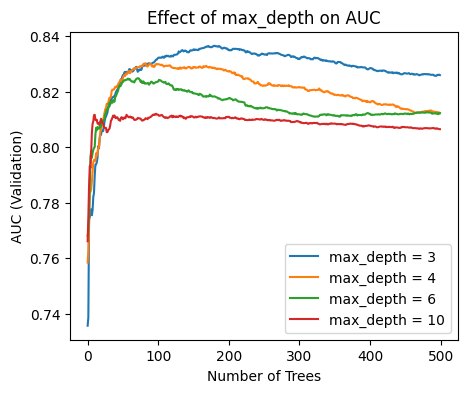

In [38]:
num_trees = range(len(eta_scores[0]))

plt.figure(figsize=(5, 4))
plt.plot(num_trees, eta_scores[0], '-', label='max_depth = 3')
plt.plot(num_trees, eta_scores[1], '-', label='max_depth = 4')
plt.plot(num_trees, eta_scores[2], '-', label='max_depth = 6')
plt.plot(num_trees, eta_scores[3], '-', label='max_depth = 10')
plt.title('Effect of max_depth on AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC (Validation)')
plt.legend()
plt.show()

The best AUC value is for `max_depth` = 3.

Finally, let's fine tune the last parameter of interest: `min_child_weight`, the minimal number of observations a tree must have in a leaf (t is the equivalent of `min_samples_leaf` for the Scikit-learn's Decision Tree algorithm). Let's try `min_child_weight` = [1, 10, 30].

In [39]:
eta_scores = []
for min_child_weight in [1, 10, 30]:
    xgb_params = {'eta': 0.1,
                  'max_depth': 3,
                  'min_child_weight': min_child_weight,
                  'objective': 'binary:logistic',
                  'nthread': 8,
                  'seed': 1,
                  'eval_metric': 'auc'}

    print("min_child_weight:", min_child_weight)
    evals_result = {} 
    model_xgb = xgb.train(xgb_params, 
                          dtrain,
                          num_boost_round=500, 
                          evals=watchlist,
                          evals_result=evals_result,  
                          verbose_eval=100)
    eta_scores.append(evals_result['val']['auc'])                     

min_child_weight: 1
[0]	train-auc:0.77424	val-auc:0.73571
[100]	train-auc:0.91801	val-auc:0.83221
[200]	train-auc:0.94334	val-auc:0.83512
[300]	train-auc:0.95733	val-auc:0.83173
[400]	train-auc:0.96875	val-auc:0.82846
[499]	train-auc:0.97642	val-auc:0.82599
min_child_weight: 10
[0]	train-auc:0.77424	val-auc:0.73571
[100]	train-auc:0.90632	val-auc:0.83130
[200]	train-auc:0.92486	val-auc:0.83133
[300]	train-auc:0.93665	val-auc:0.82974
[400]	train-auc:0.94651	val-auc:0.82569
[499]	train-auc:0.95432	val-auc:0.82249
min_child_weight: 30
[0]	train-auc:0.76588	val-auc:0.73459
[100]	train-auc:0.89334	val-auc:0.83354
[200]	train-auc:0.90527	val-auc:0.83451
[300]	train-auc:0.91489	val-auc:0.83338
[400]	train-auc:0.92208	val-auc:0.83199
[499]	train-auc:0.92766	val-auc:0.83072


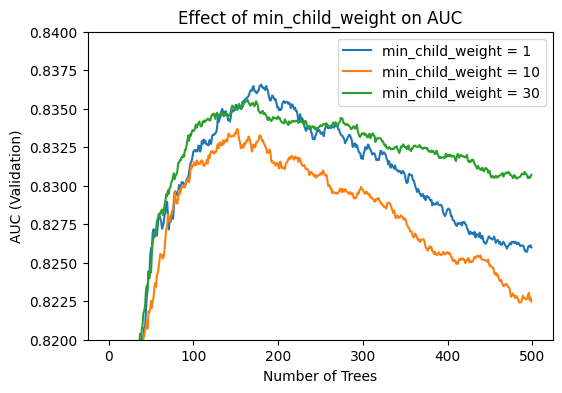

In [40]:
num_trees = range(len(eta_scores[0]))

plt.figure(figsize=(6, 4))
plt.plot(num_trees, eta_scores[0], '-', label='min_child_weight = 1')
plt.plot(num_trees, eta_scores[1], '-', label='min_child_weight = 10')
plt.plot(num_trees, eta_scores[2], '-', label='min_child_weight = 30')
plt.title('Effect of min_child_weight on AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC (Validation)')
plt.ylim([0.82, 0.84])
plt.legend()
plt.show()

`min_child_weight` = 1 has the best performance.

Now that we fine tuned all the parameters, we need to find the best number of trees. For that, it suffices to train the model again with the chosen parameters and find the peak of the AUC score.

In [41]:
xgb_params = {'eta': 0.1,
              'max_depth': 3,
              'min_child_weight': 1,
              'objective': 'binary:logistic',
              'nthread': 8,
              'seed': 1,
              'eval_metric': 'auc'}

evals_result_final = {} 
model_xgb = xgb.train(xgb_params, 
                        dtrain,
                        num_boost_round=500, 
                        evals=watchlist,
                        evals_result=evals_result_final,  
                        verbose_eval=20)                

[0]	train-auc:0.77424	val-auc:0.73571
[20]	train-auc:0.86359	val-auc:0.80617
[40]	train-auc:0.88701	val-auc:0.81990
[60]	train-auc:0.90159	val-auc:0.82806
[80]	train-auc:0.91110	val-auc:0.82940
[100]	train-auc:0.91801	val-auc:0.83221
[120]	train-auc:0.92460	val-auc:0.83285
[140]	train-auc:0.93100	val-auc:0.83463
[160]	train-auc:0.93551	val-auc:0.83554
[180]	train-auc:0.93971	val-auc:0.83657
[200]	train-auc:0.94334	val-auc:0.83512
[220]	train-auc:0.94693	val-auc:0.83508
[240]	train-auc:0.94999	val-auc:0.83336
[260]	train-auc:0.95235	val-auc:0.83379
[280]	train-auc:0.95470	val-auc:0.83288
[300]	train-auc:0.95733	val-auc:0.83173
[320]	train-auc:0.95972	val-auc:0.83201
[340]	train-auc:0.96172	val-auc:0.83101
[360]	train-auc:0.96416	val-auc:0.83034
[380]	train-auc:0.96669	val-auc:0.82905
[400]	train-auc:0.96875	val-auc:0.82846
[420]	train-auc:0.97055	val-auc:0.82764
[440]	train-auc:0.97213	val-auc:0.82659
[460]	train-auc:0.97357	val-auc:0.82642
[480]	train-auc:0.97497	val-auc:0.82635
[499]	

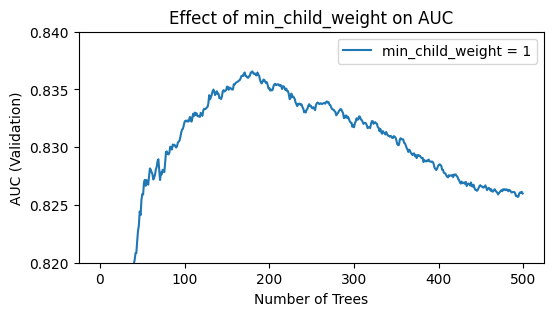

In [42]:
num_trees = range(len(evals_result_final['val']['auc']))

plt.figure(figsize=(6, 3))
plt.plot(num_trees, evals_result_final['val']['auc'], '-', label='min_child_weight = 1')
plt.title('Effect of min_child_weight on AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC (Validation)')
plt.ylim([0.82, 0.84])
plt.legend()
plt.show()

The peak is reached with 180 trees, reaching and AUC of 0.836, 1% better than the value of 0.825 of the Random Forest model. Therefore, we will use the XGBoost as our final model. 

## Testing the final model
Finally, we are going to test our final model in our test set. But first, we are going to re-train the model using the train + validation sets. Let's repeat all the previous steps for these two datasets:

In [43]:
# Generating 
y_train = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

# Deleting status
del df_train_full['status']
del df_test['status']

# Filling missing values with zeros
dict_train = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

Now, we create the DMatrix, train the final model and evaluate it.

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

model_xgb_final = xgb.train(xgb_params, 
                            dtrain,
                            num_boost_round=180)

y_pred_train = model_xgb_final.predict(dtrain)
y_pred_test = model_xgb_final.predict(dtest)

xgb_score_train = roc_auc_score(y_train, y_pred_train)
xgb_score_test = roc_auc_score(y_test, y_pred_test)

print("ROC AUC Train = {:0.3f}".format(xgb_score_train))
print("ROC AUC Test = {:0.3f}".format(xgb_score_test))

ROC AUC Train = 0.923
ROC AUC Test = 0.833


The AUC of 0.83 is very close to that of 0.836 found in the validation set. Thus, the model can generalize well to unseen data, and can be deployed to production.  